In [28]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [29]:
# データ読み込み、外れ値の除外

# データセットの読み込み
df = sns.load_dataset('diamonds')

# 外れ値除外の前処理
df = df.drop(df[(df['x'] == 0) | (df['y'] == 0)| (df['z'] == 0)].index, axis=0)
df = df.drop(df[(df['x'] >= 10) | (df['y'] >= 10) | (df['z'] >= 10)].index, axis=0)
df.reset_index(inplace=True, drop=True)
print(df.shape)
df.head()

(53911, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [30]:
# データ型
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53911 entries, 0 to 53910
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53911 non-null  float64 
 1   cut      53911 non-null  category
 2   color    53911 non-null  category
 3   clarity  53911 non-null  category
 4   depth    53911 non-null  float64 
 5   table    53911 non-null  float64 
 6   price    53911 non-null  int64   
 7   x        53911 non-null  float64 
 8   y        53911 non-null  float64 
 9   z        53911 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


In [31]:
# 特徴量と目的変数の設定
X = df.drop(['price'], axis=1)
y = df['price']

In [32]:
# 数値×数値の特徴量エンジニアリング

# 密度（重さ/体積）
X['density'] = X['carat'] / (X['x'] * X['y'] * X['z'])

# 差分
X['x-y'] = (X['x'] - X['y']).abs()
X['y-z'] = (X['y'] - X['z']).abs()
X['z-x'] = (X['x'] - X['y']).abs()

# 比率
X['x/y'] = X['x'] / X['y']
X['y/z'] = X['y'] / X['z']
X['z/x'] = X['z'] / X['x']

# 中央値との差分
X['x-median_x'] = (X['x'] - X['x'].median()).abs()
X['y-median_y'] = (X['y'] - X['y'].median()).abs()
X['z-median_z'] = (X['z'] - X['z'].median()).abs()

print('追加した特徴量')
display(X[['density', 'x/y', 'y/z', 'z/x', 'x-y', 'y-z', 'z-x', 'x-median_x', 'y-median_y', 'z-median_z']].head())

追加した特徴量


,density,x/y,y/z,z/x,x-y,y-z,z-x,x-median_x,y-median_y,z-median_z
0,0.006021,0.992462,1.637860,0.615190,0.03,1.55,0.03,1.75,1.73,1.10
1,0.006086,1.013021,1.662338,0.593830,0.05,1.53,0.05,1.81,1.87,1.22
2,0.006040,0.995086,1.761905,0.570370,0.02,1.76,0.02,1.65,1.64,1.22
3,0.006207,0.992908,1.608365,0.626190,0.03,1.60,0.03,1.50,1.48,0.90
4,0.005971,0.997701,1.581818,0.633641,0.01,1.60,0.01,1.36,1.36,0.78


In [33]:
# カテゴリ変数cutで集計したcarat中央値の特徴量追加

# カテゴリ変数cutごとにcarat中央値を集計
X_carat_by_cut = X.groupby('cut')['carat'].agg('median').reset_index()
X_carat_by_cut.columns = ['cut', 'median_carat_by_cut']

print('cutごとのcarat中央値')
display(X_carat_by_cut)

# 集計した特徴量の追加
X = pd.merge(X, X_carat_by_cut, on='cut', how='left')

# caratとcarat中央値の差分
X['carat-median_carat_by_cut'] = (X['carat'] - X['median_carat_by_cut'])

# # caratとcarat中央値の比率
X['carat/median_carat_by_cut'] = (X['carat'] / X['median_carat_by_cut'])

print('カテゴリ変数＋追加した特徴量')
display(X[['cut', 'carat', 'median_carat_by_cut', 'carat-median_carat_by_cut', 'carat/median_carat_by_cut']].head())

cutごとのcarat中央値


<ipython-input-33-a2baeb16e68a>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_carat_by_cut = X.groupby('cut')['carat'].agg('median').reset_index()


,cut,median_carat_by_cut
0,Ideal,0.54
1,Premium,0.85
2,Very Good,0.71
3,Good,0.82
4,Fair,1.00


カテゴリ変数＋追加した特徴量


,cut,carat,median_carat_by_cut,carat-median_carat_by_cut,carat/median_carat_by_cut
0,Ideal,0.23,0.54,-0.31,0.425926
1,Premium,0.21,0.85,-0.64,0.247059
2,Good,0.23,0.82,-0.59,0.280488
3,Premium,0.29,0.85,-0.56,0.341176
4,Good,0.31,0.82,-0.51,0.378049


In [34]:
# カテゴリ変数colorで集計したcarat中央値の特徴量追加

# カテゴリ変数colorごとにcarat中央値を集計
X_carat_by_color = X.groupby('color')['carat'].agg('median').reset_index()
X_carat_by_color.columns = ['color', 'median_carat_by_color']
print('colorごとのcarat中央値')
display(X_carat_by_color)

# 集計した特徴量の追加
X = pd.merge(X, X_carat_by_color, on='color', how = 'left')

# caratとcarat中央値の差分
X['carat-median_carat_by_color'] = (X['carat'] - X['median_carat_by_color'])
# caratとcarat中央値の比率
X['carat/median_carat_by_color'] = (X['carat'] / X['median_carat_by_color'])

print('カテゴリ変数＋追加した特徴量')
display(X[['color', 'carat', 'median_carat_by_color', 'carat-median_carat_by_color', 'carat/median_carat_by_color']].head())

colorごとのcarat中央値


<ipython-input-34-51a223e61d5e>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_carat_by_color = X.groupby('color')['carat'].agg('median').reset_index()


,color,median_carat_by_color
0,D,0.53
1,E,0.53
2,F,0.70
3,G,0.70
4,H,0.90
5,I,1.00
6,J,1.11


カテゴリ変数＋追加した特徴量


,color,carat,median_carat_by_color,carat-median_carat_by_color,carat/median_carat_by_color
0,E,0.23,0.53,-0.30,0.433962
1,E,0.21,0.53,-0.32,0.396226
2,E,0.23,0.53,-0.30,0.433962
3,I,0.29,1.00,-0.71,0.290000
4,J,0.31,1.11,-0.80,0.279279


In [35]:
# カテゴリ変数clarityで集計したcarat中央値の特徴量追加

# カテゴリ変数clarityごとにcarat中央値を集計
X_carat_by_clarity = X.groupby('clarity')['carat'].agg('median').reset_index()
X_carat_by_clarity.columns = ['clarity', 'median_carat_by_clarity']
print('clarityごとのcarat中央値')
display(X_carat_by_clarity)

# 集計した特徴量の追加
X = pd.merge(X, X_carat_by_clarity, on='clarity', how = 'left')

# caratとcarat中央値の差分
X['carat-median_carat_by_clarity'] = (X['carat'] - X['median_carat_by_clarity'])
# caratとcarat中央値の比率
X['carat/median_carat_by_clarity'] = (X['carat'] / X['median_carat_by_clarity'])


print('カテゴリ変数＋追加した特徴量')
display(X[['clarity', 'carat', 'median_carat_by_clarity', 'carat-median_carat_by_clarity', 'carat/median_carat_by_clarity']].head())

clarityごとのcarat中央値


<ipython-input-35-8efcc8901a38>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_carat_by_clarity = X.groupby('clarity')['carat'].agg('median').reset_index()


,clarity,median_carat_by_clarity
0,IF,0.35
1,VVS1,0.39
2,VVS2,0.44
3,VS1,0.57
4,VS2,0.63
5,SI1,0.76
6,SI2,1.01
7,I1,1.11


カテゴリ変数＋追加した特徴量


,clarity,carat,median_carat_by_clarity,carat-median_carat_by_clarity,carat/median_carat_by_clarity
0,SI2,0.23,1.01,-0.78,0.227723
1,SI1,0.21,0.76,-0.55,0.276316
2,VS1,0.23,0.57,-0.34,0.403509
3,VS2,0.29,0.63,-0.34,0.460317
4,SI2,0.31,1.01,-0.70,0.306931


In [36]:
# カテゴリ変数cut×colorで集計した出現割合の特徴量追加

# クロス集計表の出現割合
X_cross = pd.crosstab(X['cut'], X['color'], normalize='index')
X_cross = X_cross.reset_index()
print('cut*colorのクロス集計表')
display(X_cross)

# クロス集計表のテーブルへの変換
X_tbl = pd.melt(X_cross, id_vars='cut', value_name='rate_cut*color')
print('cut*colorのテーブル')
display(X_tbl.head())

# 出現割合の特徴量追加
X = pd.merge(X, X_tbl, on=['cut', 'color'], how='left' )
print('カテゴリ変数＋追加した特徴量')
display(X[['cut', 'color', 'clarity', 'rate_cut*color']].head())

cut*colorのクロス集計表


color,cut,D,E,F,G,H,I,J
0,Ideal,0.131526,0.181092,0.177519,0.226574,0.144568,0.097136,0.041584
1,Premium,0.116281,0.169631,0.169122,0.212020,0.170864,0.103506,0.058576
2,Very Good,0.125259,0.198609,0.179154,0.190330,0.150923,0.099594,0.056130
3,Good,0.135047,0.190330,0.185027,0.177275,0.143207,0.106487,0.062627
4,Fair,0.101494,0.139477,0.194271,0.194894,0.188045,0.108966,0.072852


cut*colorのテーブル


,cut,color,rate_cut*color
0,Ideal,D,0.131526
1,Premium,D,0.116281
2,Very Good,D,0.125259
3,Good,D,0.135047
4,Fair,D,0.101494


カテゴリ変数＋追加した特徴量


,cut,color,clarity,rate_cut*color
0,Ideal,E,SI2,0.181092
1,Premium,E,SI1,0.169631
2,Good,E,VS1,0.190330
3,Premium,I,VS2,0.103506
4,Good,J,SI2,0.062627


In [37]:
# カテゴリ変数color×clarityで集計した出現割合の特徴量追加

# クロス集計表の出現割合
X_cross = pd.crosstab(X['color'], X['clarity'], normalize='index')
X_cross = X_cross.reset_index()
print('color*clarityのクロス集計表')
display(X_cross)

# クロス集計表のテーブルへの変換
X_tbl = pd.melt(X_cross, id_vars='color', value_name='rate_color*clarity')
print('color*clarityのテーブル')
display(X_tbl.head())

# 出現割合の特徴量追加
X = pd.merge(X, X_tbl, on=['color', 'clarity'], how='left' )
print('カテゴリ変数＋追加した特徴量')
display(X[['cut', 'color', 'clarity', 'rate_color*clarity']].head())

color*clarityのクロス集計表


clarity,color,IF,VVS1,VVS2,VS1,VS2,SI1,SI2,I1
0,D,0.010776,0.037053,0.081636,0.104074,0.250517,0.307499,0.202244,0.006200
1,E,0.016131,0.066973,0.101174,0.130577,0.252169,0.247677,0.174885,0.010413
2,F,0.040365,0.076955,0.102223,0.143007,0.230761,0.223422,0.168274,0.014993
3,G,0.060351,0.088532,0.127880,0.190269,0.207816,0.175115,0.136920,0.013116
4,H,0.036041,0.070516,0.073288,0.140911,0.197806,0.274108,0.188042,0.019286
5,I,0.026389,0.065510,0.067356,0.177524,0.215722,0.262595,0.168297,0.016608
6,J,0.018182,0.026381,0.046702,0.193226,0.260606,0.267380,0.170766,0.016756


color*clarityのテーブル


,color,clarity,rate_color*clarity
0,D,IF,0.010776
1,E,IF,0.016131
2,F,IF,0.040365
3,G,IF,0.060351
4,H,IF,0.036041


カテゴリ変数＋追加した特徴量


,cut,color,clarity,rate_color*clarity
0,Ideal,E,SI2,0.174885
1,Premium,E,SI1,0.247677
2,Good,E,VS1,0.130577
3,Premium,I,VS2,0.215722
4,Good,J,SI2,0.170766


In [38]:
# カテゴリ変数clarity×cutで集計した出現割合の特徴量追加

# クロス集計表の出現割合
X_cross = pd.crosstab(X['clarity'], X['cut'], normalize='index')
X_cross = X_cross.reset_index()
print('clarity*cutのクロス集計表')
display(X_cross)

# クロス集計表のテーブルへの変換
X_tbl = pd.melt(X_cross, id_vars='clarity', value_name='rate_clarity*cut')
print('clarity*cutのテーブル')
display(X_tbl.head())

# 出現割合の特徴量追加
X = pd.merge(X, X_tbl, on=['clarity', 'cut'], how='left' )
print('カテゴリ変数＋追加した特徴量')
display(X[['cut', 'color', 'clarity', 'rate_clarity*cut']].head())

clarity*cutのクロス集計表


cut,clarity,Ideal,Premium,Very Good,Good,Fair
0,I1,0.199454,0.274590,0.113388,0.129781,0.282787
1,IF,0.677095,0.128492,0.149721,0.039665,0.005028
2,SI1,0.327796,0.273521,0.248029,0.119421,0.031233
3,SI2,0.282774,0.320449,0.228659,0.117378,0.050740
4,VS1,0.439275,0.243511,0.217189,0.079334,0.020690
5,VS2,0.413661,0.273870,0.211360,0.079811,0.021299
6,VVS1,0.560208,0.168309,0.215928,0.050903,0.004652
7,VVS2,0.514410,0.171733,0.243782,0.056455,0.013620


clarity*cutのテーブル


,clarity,cut,rate_clarity*cut
0,I1,Ideal,0.199454
1,IF,Ideal,0.677095
2,SI1,Ideal,0.327796
3,SI2,Ideal,0.282774
4,VS1,Ideal,0.439275


カテゴリ変数＋追加した特徴量


,cut,color,clarity,rate_clarity*cut
0,Ideal,E,SI2,0.282774
1,Premium,E,SI1,0.273521
2,Good,E,VS1,0.079334
3,Premium,I,VS2,0.273870
4,Good,J,SI2,0.117378


In [39]:
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)

X_trainの形状： (43128, 31)  y_trainの形状： (43128,)  X_testの形状： (10783, 31)  y_testの形状： (10783,)


In [40]:
# カテゴリ変数のlabel encoding
from sklearn.preprocessing import LabelEncoder

cat_cols = ['cut', 'color', 'clarity']

for c in cat_cols:
    le = LabelEncoder()
    le.fit(X_train[c])
    X_train[c] = le.transform(X_train[c])
    X_test[c] = le.transform(X_test[c])

In [41]:
# カテゴリ変数のデータ型をcategory型に変換
cat_cols = ['cut', 'color', 'clarity']

for c in cat_cols:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43128 entries, 2640 to 2732
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   carat                          43128 non-null  float64 
 1   cut                            43128 non-null  category
 2   color                          43128 non-null  category
 3   clarity                        43128 non-null  category
 4   depth                          43128 non-null  float64 
 5   table                          43128 non-null  float64 
 6   x                              43128 non-null  float64 
 7   y                              43128 non-null  float64 
 8   z                              43128 non-null  float64 
 9   density                        43128 non-null  float64 
 10  x-y                            43128 non-null  float64 
 11  y-z                            43128 non-null  float64 
 12  z-x                            4312

In [43]:
# 学習データの一部を検証データに分割
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=0)
print('X_trの形状：', X_tr.shape, ' y_trの形状：', y_tr.shape, ' X_vaの形状：', X_va.shape, ' y_vaの形状：', y_va.shape)

X_trの形状： (34502, 31)  y_trの形状： (34502,)  X_vaの形状： (8626, 31)  y_vaの形状： (8626,)


In [44]:
# ハイパーパラメータの設定
import lightgbm as lgb

lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)

params = {
    'objective': 'mae',
    'seed': 0,
    'verbose': -1,
}

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [45]:
# モデルの学習
model = lgb.train(params,
                  lgb_train,
                  num_boost_round=10000,
                  valid_sets=[lgb_train, lgb_eval],
                  valid_names=['train', 'valid'],
                  callbacks=[lgb.early_stopping(100),
                             lgb.log_evaluation(500)])

y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
score = mean_absolute_error(y_va, y_va_pred)
print(f'MAE valid: {score:.2f}')

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.688	valid's l1: 251.401
Early stopping, best iteration is:
[853]	train's l1: 193.728	valid's l1: 249.942
MAE valid: 249.94


In [46]:
# 検証データの予測と評価
y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
print('MAE valid: %.2f' % (mean_absolute_error(y_va, y_va_pred)))

MAE valid: 249.94


In [47]:
# テストデータの予測と評価
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('MAE test: %.2f' % (mean_absolute_error(y_test, y_test_pred)))

MAE test: 249.80


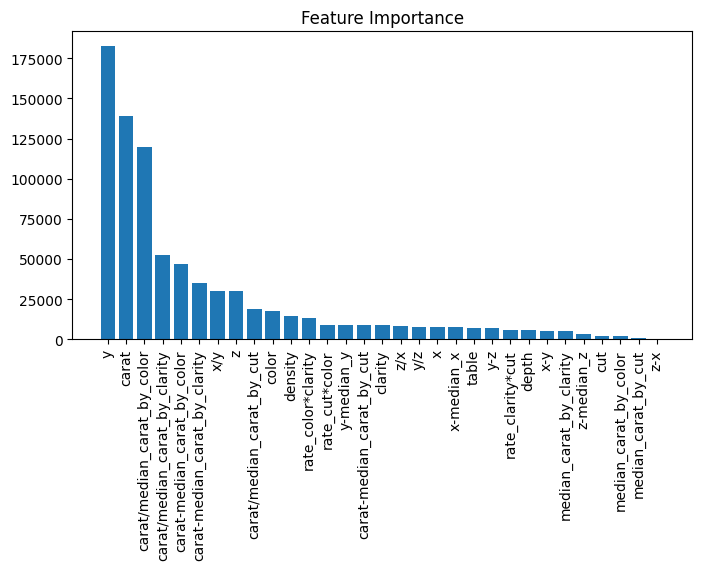

In [48]:
# 特徴量重要度の可視化
importances = model.feature_importance(importance_type='gain') # 特徴量重要度
indices = np.argsort(importances)[::-1] # 特徴量重要度を降順にソート

plt.figure(figsize=(8, 4))
plt.title('Feature Importance')
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加
plt.show()

In [49]:
# クロスバリデーション
from sklearn.model_selection import KFold

# 格納用データの作成
valid_scores = []
models = []
oof = np.zeros(len(X_train))

# KFoldを用いて学習データを5分割してモデルを作成
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train)):
    X_tr = X_train.iloc[tr_idx]
    X_va = X_train.iloc[va_idx]
    y_tr = y_train.iloc[tr_idx]
    y_va = y_train.iloc[va_idx]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)

    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=10000,
                      valid_sets=[lgb_train, lgb_eval],
                      valid_names=['train', 'valid'],
                      callbacks=[lgb.early_stopping(100),
                      lgb.log_evaluation(500)])

    y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
    score = mean_absolute_error(y_va, y_va_pred)
    print(f'fold {fold+1} MAE valid: {score:.2f}')
    print('')

    # スコア、モデル、予測値の格納
    valid_scores.append(score)
    models.append(model)
    oof[va_idx] = y_va_pred

# クロスバリデーションの平均スコア
cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score:.2f}')

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.688	valid's l1: 251.401
Early stopping, best iteration is:
[853]	train's l1: 193.728	valid's l1: 249.942
fold 1 MAE valid: 249.94

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.153	valid's l1: 254.308
[1000]	train's l1: 192.958	valid's l1: 251.931
Early stopping, best iteration is:
[1148]	train's l1: 188.775	valid's l1: 251.551
fold 2 MAE valid: 251.55

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.005	valid's l1: 258.014
Early stopping, best iteration is:
[850]	train's l1: 194.42	valid's l1: 256.28
fold 3 MAE valid: 256.28

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.942	valid's l1: 259.517
[1000]	train's l1: 189.189	valid's l1: 256.646
Early stopping, best iteration is:
[1036]	train's l1: 188.34	valid's l1: 256.603
fold 4 MAE valid: 256.60

Training until validation scores don't improve 

In [50]:
# foldごとの検証データの誤差
valid_scores

[249.94207739600932,
 251.55081302400225,
 256.27994374418546,
 256.60311421408,
 254.74068152612642]